<a href="https://colab.research.google.com/github/NastaCom/ML_for_business/blob/main/HW_4_GorokhovaA_is.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Домашнее задание

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. провести uplift-моделирование 3 способами:
    1. одна модель с признаком коммуникации (S-learner)
    2. модель с трансформацией таргета
    3. вариант с двумя независимыми моделями
5. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% 3 моделей
6. *для модели S-learner построить зависимость таргета (конверсии - поле conversion) от значения uplift:
    1. сделать прогноз и получить uplift для тестовой выборки
    2. отсортировать тестовую выборку по uplift по убыванию
    3. разбить на децили (pandas qcut вам в помощь)
    4. для каждого дециля посчитать среднюю conversion

### Уж очень хочется вначале посмотреть на данные. Поэтому вначале прочитаю файл, а затем импортирую все необходимые библиотеки для работы

##### а еще мне удобно писать шпаргалки по признакам
recency - месяцев с момента последней покупки

history - стоимость исторических покупок

used_discount - указывает, использовал ли клиент скидку до

used_bogo - указывает, использовал ли клиент функцию «купить, получить, прежде чем»

zip_code - класс почтового индекса как пригородный / городской / сельский

is_referral - указывает, был ли клиент привлечен по реферальному каналу

channel - каналы, которые использует клиент, телефон/веб/многоканальный

offer - предложения, отправленные клиентам, скидка / но один получает один / нет предложения

conversion - конверсия клиента (купит или нет)

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("data.csv")
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


#### И сразу же (по заданию) переименую поля (conversion -> target, offer -> treatment) и приведу поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [ ]:
df.rename(columns={"conversion": "target", "offer": "treatment"}, inplace=True)
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [ ]:
df.isna().sum()

recency          0
history          0
used_discount    0
used_bogo        0
zip_code         0
is_referral      0
channel          0
treatment        0
target           0
dtype: int64

In [ ]:
# df = pd.concat([df, pd.get_dummies(df['treatment'])], axis=1)
# df.head()

In [ ]:
df.loc[df['treatment'] != 'No Offer', 'treatment'] = 1
df.loc[df['treatment'] == 'No Offer', 'treatment'] = 0

In [ ]:
df['treatment'] = df['treatment'].astype(str).astype(int)
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


#### Импортируем нужные библиотеки и предобработаем данные 

In [ ]:
!pip install scikit-uplift==0.2.0

In [ ]:
!pip install catboost

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split

# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k, uplift_by_percentile, uplift_auc_score, qini_auc_score
from sklift.viz import plot_uplift_preds, plot_uplift_by_percentile, plot_uplift_curve, plot_qini_curve
from sklift.models import SoloModel, ClassTransformation, TwoModels

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier

from sklearn.utils.validation import check_consistent_length
import matplotlib.pyplot as plt

In [ ]:
# замена для родной функции из skuplift
def plot_uplift_preds_(trmnt_preds, ctrl_preds, log=False, bins=100):
    """Plot histograms of treatment, control and uplift predictions.

    Args:
        trmnt_preds (1d array-like): Predictions for all observations if they are treatment.
        ctrl_preds (1d array-like): Predictions for all observations if they are control.
        log (bool): Logarithm of source samples. Default is False.
        bins (integer or sequence): Number of histogram bins to be used. Default is 100.
            If an integer is given, bins + 1 bin edges are calculated and returned.
            If bins is a sequence, gives bin edges, including left edge of first bin and right edge of last bin.
            In this case, bins is returned unmodified. Default is 100.

    Returns:
        Object that stores computed values.
    """

    # TODO: Add k as parameter: vertical line on plots
    check_consistent_length(trmnt_preds, ctrl_preds)
  
    if not isinstance(bins, int) or bins <= 0:
        raise ValueError(
            f'Bins should be positive integer. Invalid value for bins: {bins}')

    if log:
        trmnt_preds = np.log(trmnt_preds + 1)
        ctrl_preds = np.log(ctrl_preds + 1)

    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 7))
    axes[0].hist(
        trmnt_preds, bins=bins, alpha=0.3, color='b', label='Treated', histtype='stepfilled')
    axes[0].set_ylabel('Probability hist')
    axes[0].legend()
    axes[0].set_title('Treatment predictions')

    axes[1].hist(
        ctrl_preds, bins=bins, alpha=0.5, color='y', label='Not treated', histtype='stepfilled')
    axes[1].legend()
    axes[1].set_title('Control predictions')

    axes[2].hist(
        trmnt_preds - ctrl_preds, bins=bins, alpha=0.5, color='green', label='Uplift', histtype='stepfilled')
    axes[2].legend()
    axes[2].set_title('Uplift predictions')

    return axes

#### Разобью набор данных не тренировочную и тестовую выборки

In [ ]:
X = df.drop(columns=["target"])
y = df["target"]

X_train_, X_test_, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
X_train = X_train_.drop(columns=["treatment"])
treat_train = X_train_['treatment']

X_test = X_test_.drop(columns=["treatment"])
treat_test = X_test_['treatment']

cat_features = ['zip_code', 'channel']

### Одна модель с признаком коммуникации

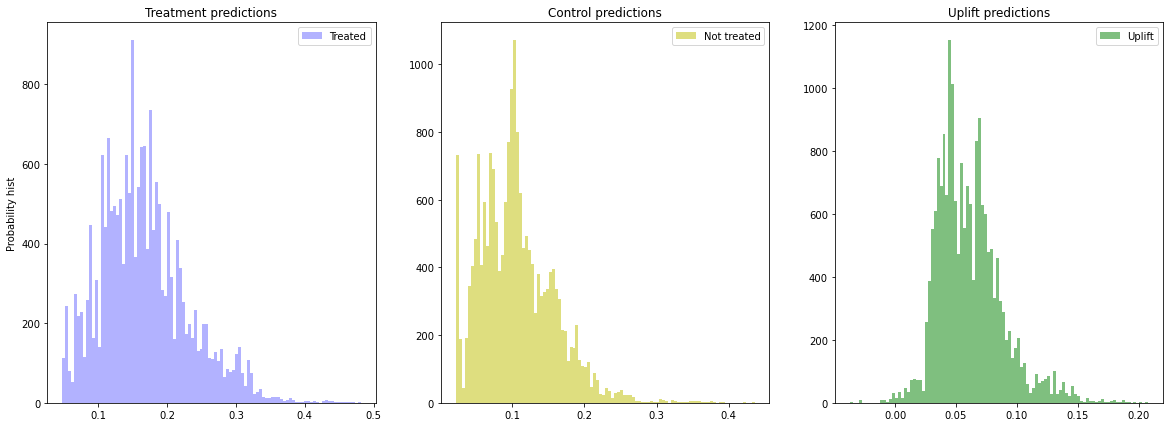

In [ ]:
models_results = {
    'approach': [],
    'uplift@10%': [], 
    'uplift@20%': []
}

sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
# sm = sm.fit(X_train, y_train, treat_train)
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})
uplift_sm = sm.predict(X_test)

# размер uplift на топ k процентах выборки
sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds); #ctrl_preds=

In [ ]:
n = 15
df_ul = pd.DataFrame({
    'true': y_test[:n],
    'uplift': uplift_sm[:n],
    'treat': treat_test[:n]
})   
df_ul 

,true,uplift,treat
44324,0,0.078900,1
61882,0,0.042996,0
10998,0,0.094623,1
49127,0,0.078331,1
1849,0,0.030022,0
15252,0,0.043833,1
6706,0,0.043599,1
12865,0,0.084638,1
41670,0,0.053532,1
37415,0,0.069925,0


#### Посмотрим на топ-признаки

In [ ]:
sm_ff = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_ff

,feature_name,feature_score
0,is_referral,18.927835
1,treatment,17.327660
2,recency,12.882007
3,used_bogo,11.700580
4,channel,11.365476
5,zip_code,10.239545
6,used_discount,8.938033
7,history,8.618864


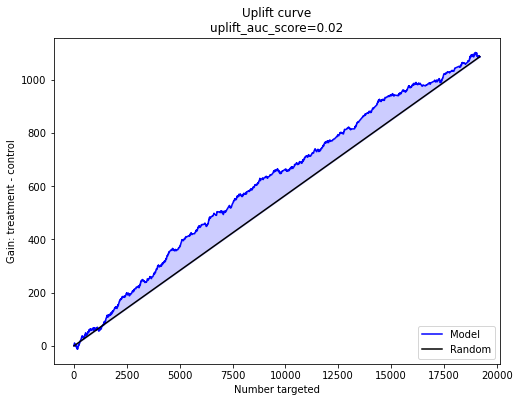

In [ ]:
plot_uplift_curve(y_test, uplift_sm, treat_test, perfect=False); # perfect=True

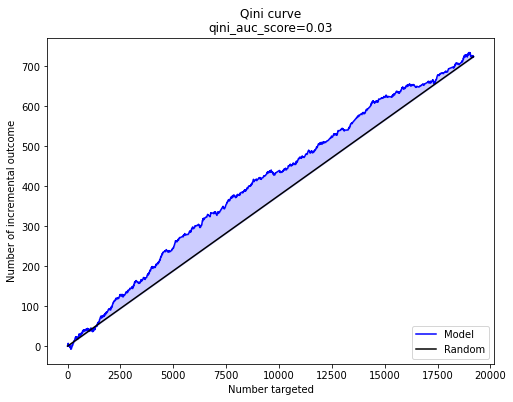

In [ ]:
plot_qini_curve(y_test, uplift_sm, treat_test, perfect=False);

In [ ]:
uplift_by_percentile(y_test, uplift_sm,  treat_test, 
                     strategy='overall', 
                     total=True, std=True, bins=10)

C:\Users\User\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
10.0,1233,687,0.242498,0.168850,0.073648,0.012206,0.014293,0.018795
20.0,1295,625,0.184556,0.110400,0.074156,0.010780,0.012536,0.016533
30.0,1290,630,0.192248,0.111111,0.081137,0.010972,0.012521,0.016648
40.0,1276,644,0.184169,0.121118,0.063051,0.010851,0.012857,0.016824
50.0,1267,653,0.163378,0.105666,0.057712,0.010387,0.012030,0.015893
60.0,1272,648,0.153302,0.114198,0.039104,0.010102,0.012494,0.016067
70.0,1287,633,0.126651,0.071090,0.055561,0.009271,0.010214,0.013794
80.0,1273,647,0.139042,0.085008,0.054034,0.009697,0.010964,0.014637
90.0,1288,632,0.124224,0.093354,0.030869,0.009191,0.011573,0.014778


C:\Users\User\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


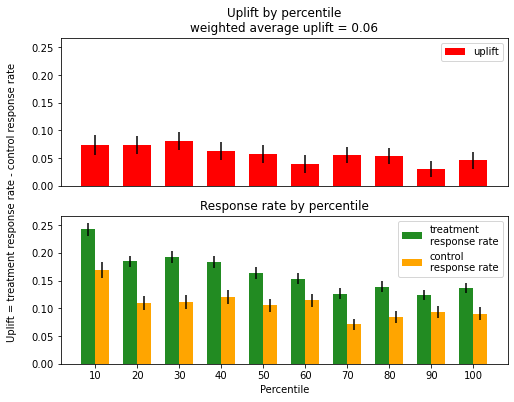

In [ ]:
plot_uplift_by_percentile(y_test, uplift_sm, treat_test, 
                          strategy='overall', kind='bar'); # line

In [ ]:
from sklift.metrics import weighted_average_uplift

# с помощью значений в столбцах uplift и n_treatment рассчитаем усредненный uplift на всей выборке, 
# взвешенный на размер целевой группы — weighted average uplift
uplift_full_data = weighted_average_uplift(y_test, uplift_sm, 
                                            treat_test, bins=10) 
print(f"weighted average uplift on full data: {uplift_full_data:.4f}")

weighted average uplift on full data: 0.0575


### Трансформация классов

In [ ]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

<ipython-input-97-34878d72a1f4>:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})


### Две независимые модели

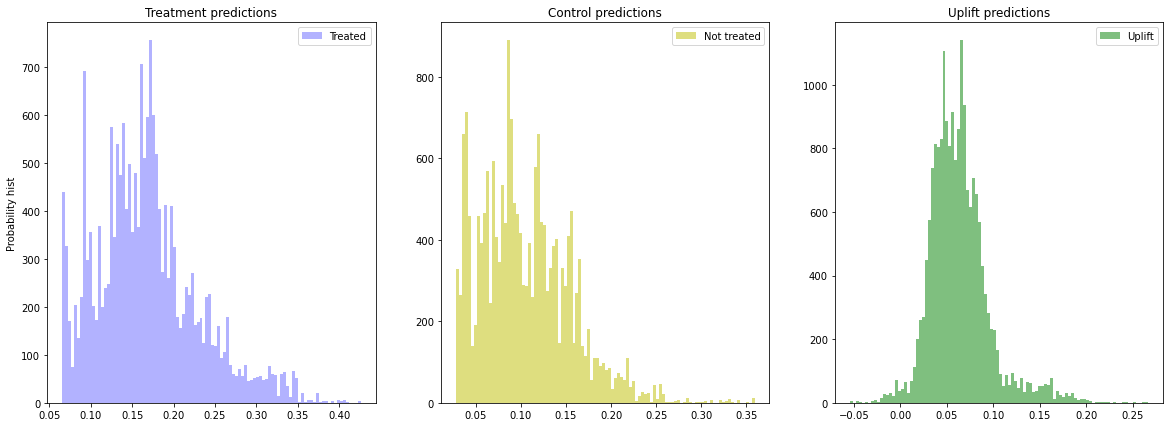

In [ ]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)


models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [ ]:
pd.DataFrame(data=models_results).sort_values('uplift@20%', ascending=False)

,approach,uplift@10%,uplift@20%
2,TwoModels,0.066474,0.072533
0,SoloModel,0.066456,0.071769
1,ClassTransformation,0.069523,0.059188


#### *для модели S-learner построить зависимость таргета (конверсии - поле conversion) от значения uplift:
    1. сделать прогноз и получить uplift для тестовой выборки
    2. отсортировать тестовую выборку по uplift по убыванию
    3. разбить на децили (pandas qcut вам в помощь)
    4. для каждого дециля посчитать среднюю conversion

#### Не уверена, что сделаю правильно, но попробую

In [ ]:
X_test_uplift = X_test
X_test_uplift['uplift'] = uplift_sm
X_test_uplift['conversion'] = y_test

In [ ]:
X_test_uplift = X_test_uplift.sort_values(['uplift'], ascending=False)
X_test_uplift.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,uplift,conversion
954,10,240.26,1,1,Rural,1,Web,0.207996,0
42879,10,230.04,1,1,Rural,1,Multichannel,0.207629,0
39210,10,234.68,1,1,Rural,1,Multichannel,0.207629,1
18549,9,212.31,1,1,Rural,1,Web,0.207145,0
60018,1,265.11,1,1,Rural,1,Multichannel,0.200666,0


In [ ]:
X_test_uplift['qcut']=pd.qcut(X_test_uplift['uplift'], 4, labels=False)
X_test_uplift

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,uplift,conversion,qcut
954,10,240.26,1,1,Rural,1,Web,0.207996,0,3
42879,10,230.04,1,1,Rural,1,Multichannel,0.207629,0,3
39210,10,234.68,1,1,Rural,1,Multichannel,0.207629,1,3
18549,9,212.31,1,1,Rural,1,Web,0.207145,0,3
60018,1,265.11,1,1,Rural,1,Multichannel,0.200666,0,3
...,...,...,...,...,...,...,...,...,...,...
15209,2,353.69,1,0,Rural,0,Phone,-0.029182,0,0
27978,2,346.99,1,0,Rural,0,Phone,-0.029182,0,0
52171,2,269.64,1,0,Rural,0,Phone,-0.029311,0,0
30070,2,271.06,1,0,Rural,0,Phone,-0.029311,0,0


In [ ]:
X_test_uplift_сat = X_test_uplift[X_test_uplift['qcut'] == 0]
X_test_uplift_сat['conversion'].mean()

0.12101645490522808

In [ ]:
X_test_uplift_сat1 = X_test_uplift[X_test_uplift['qcut'] == 1]
X_test_uplift_сat1['conversion'].mean()

0.12154006243496358

In [ ]:
X_test_uplift_сat2 = X_test_uplift[X_test_uplift['qcut'] == 2]
X_test_uplift_сat2['conversion'].mean()

0.15392626536138304

In [ ]:
X_test_uplift_сat3 = X_test_uplift[X_test_uplift['qcut'] == 3]
X_test_uplift_сat3['conversion'].mean()

0.18547882328395576